# Setup

The implementation is given by: https://keras.io/examples/vision/image_classification_with_vision_transformer/

In [1]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.optimizers import SGD, Adam
from tensorflow_addons.optimizers import AdamW
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import pickle

In [4]:
!nvidia-smi

Tue Feb  7 15:54:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    50W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Feb  7 15:54:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    50W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


# Prepare the data

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
dataset_dir = "gdrive/MyDrive/hyper-kvasir-dataset-final"

In [8]:
def get_dataCategories(dataset_dir):
    import glob

    categories = []
    for folder_name in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, folder_name)):
            nbr_files = len(
                glob.glob(os.path.join(dataset_dir, folder_name) + "/*.jpg")
            )
            categories.append(np.array([folder_name, nbr_files]))

    categories.sort(key=lambda a: a[0])
    cat = np.array(categories)

    return list(cat[:, 0]), list(cat[:, 1])

categories, nbr_files = get_dataCategories(dataset_dir)

# Create DataFrame
df = pd.DataFrame({"categorie": categories, "numbre of files": nbr_files})
print("number of categories: ", len(categories))
df

number of categories:  23


,categorie,numbre of files
0,barretts,41
1,barretts-short-segment,53
2,bbps-0-1,646
3,bbps-2-3,1158
4,cecum,1027
5,dyed-lifted-polyps,1002
6,dyed-resection-margins,989
7,esophagitis-a,413
8,esophagitis-b-d,260
9,hemorrhoids,6


## Obtaining the entire data and labels

In [9]:
def get_x_y(datadir, categories, img_wid, img_high):
    X, y = [], []
    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                ima_resize_rgb = cv2.resize(img_array, (img_wid, img_high))

                X.append(ima_resize_rgb)
                y.append(class_num)

            except Exception as e:
                print(e)

    y = np.array(y)
    X = np.array(X)

    # reshape X into img_wid x img_high x 3
    X = X.reshape(X.shape[0], img_wid, img_high, 3)

    return X, y


img_wid, img_high = 224, 224
X, y = get_x_y(dataset_dir, categories, img_wid, img_high)

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (10740, 224, 224, 3)
y: (10740,)


## Visualize the data

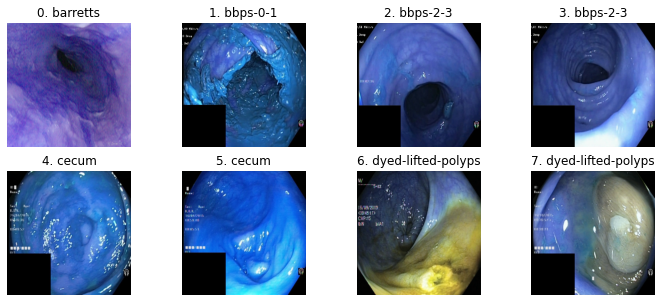

In [51]:
plt.figure(figsize=(12, 5))
st, end = 0, 500
for i in range(8):
    plt.subplot(2, 4, i + 1)
    idx = np.random.randint(st, end)
    st = end + 1
    end = (i + 2) * 500
    plt.imshow(X[idx][:, :, ::-1])
    plt.title(f"{i}. {categories[y[idx]]}")
    plt.axis("off")
plt.show()

## Split the data into train and test

In [10]:
Y = np.reshape(y, (len(y), 1))


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, train_size=0.8, random_state=42
)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (8592, 224, 224, 3)
y_train: (8592, 1)
X_test: (2148, 224, 224, 3)
y_test: (2148, 1)


# Data augmentation

In [53]:
# Data augmentation

image_size = 224

data_augmentation = keras.Sequential(
    [
        keras.layers.Normalization(),
        keras.layers.Resizing(image_size, image_size),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(factor=0.02),
        keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

# Building the ViT model

[Model diagram](https://viso.ai/wp-content/uploads/2021/09/vision-transformer-vit.png)

## Multi-Layer-Perceptron (MLP)

In [54]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Patch creation layer

In [55]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


## Hyper-parameters

In [106]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 250
image_size = 224  # We'll resize input images to this size
patch_size = 12  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

(-0.5, 223.5, 223.5, -0.5)

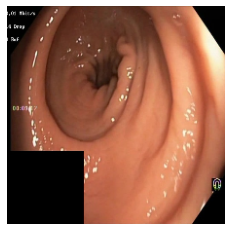

In [57]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

Image size: 224 X 224
Patch size: 12 X 12
Patches per image: 324
Elements per patch: 432


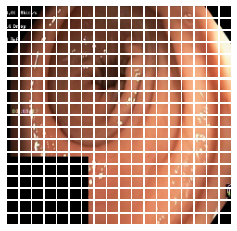

In [58]:
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Patch encoding layer

In [59]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


# Final ViT model

In [61]:
num_classes = 23
input_shape = (224, 224, 3)

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


# Run the experiment

In [62]:
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


In [63]:
model = create_vit_classifier()
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 224, 224, 3)  7          ['input_8[0][0]']                
                                                                                                  
 patches_10 (Patches)           (None, None, 432)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder_7 (PatchEncoder)  (None, 324, 64)     48448       ['patches_10[0][0]']       

In [3]:
!pip install wandb
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 22.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.2 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=1c157ffeb3f0c24976977089b030fc6378a79d0f3106e55a8b98b0c5ce5082da
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="hyper-kvasir", entity="ava-research-hyper-kvasir")

In [110]:
wandb.config = {
  "learning_rate": learning_rate,
  "epochs": num_epochs,
  "batch_size": batch_size,
  "weight_decay": weight_decay,
  "image_size": image_size,  
  "patch_size": patch_size,
  "num_patches": num_patches,
  "projection_dim": projection_dim,
  "num_heads": num_heads,
  "transformer_units_x": projection_dim * 2,
  "transformer_units_y": projection_dim,
  "transformer_layers": 8,
  "mlp_head_units_x": 2048,
  "mlp_head_units_y": 1024
}

In [ ]:
def run_experiment(model):
    optimizer = AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_model_name = "model_1-" + datetime.now().strftime("%d|%m|%Y-%H:%M:%S") + ".h5"
    checkpoint_filepath = f"gdrive/MyDrive/Universidad/TFG/trainings/checkpoints/{checkpoint_model_name}"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )


    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback, WandbCallback()],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")


    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

history_name = "model_1-" + datetime.now().strftime("%d|%m|%Y-%H:%M:%S") + ".log"

with open(f'gdrive/MyDrive/Universidad/TFG/trainings/logs/{history_name}', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/250
31/31 [==============================] - ETA: 0s - loss: 3.4850 - accuracy: 0.3357 - top-5-accuracy: 0.7486

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20230207_171538-ytbvwo9y/files/model-best)... Done. 1.6s


31/31 [==============================] - 38s 917ms/step - loss: 3.4850 - accuracy: 0.3357 - top-5-accuracy: 0.7486 - val_loss: 1.4058 - val_accuracy: 0.5453 - val_top-5-accuracy: 0.9419
Epoch 2/250
31/31 [==============================] - ETA: 0s - loss: 1.6612 - accuracy: 0.4882 - top-5-accuracy: 0.8999

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20230207_171538-ytbvwo9y/files/model-best)... Done. 1.5s


31/31 [==============================] - 27s 885ms/step - loss: 1.6612 - accuracy: 0.4882 - top-5-accuracy: 0.8999 - val_loss: 1.1787 - val_accuracy: 0.5953 - val_top-5-accuracy: 0.9535
Epoch 3/250
31/31 [==============================] - ETA: 0s - loss: 1.4173 - accuracy: 0.5413 - top-5-accuracy: 0.9263

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20230207_171538-ytbvwo9y/files/model-best)... Done. 1.7s


31/31 [==============================] - 29s 940ms/step - loss: 1.4173 - accuracy: 0.5413 - top-5-accuracy: 0.9263 - val_loss: 1.0530 - val_accuracy: 0.6419 - val_top-5-accuracy: 0.9698
Epoch 4/250
31/31 [==============================] - ETA: 0s - loss: 1.2152 - accuracy: 0.5917 - top-5-accuracy: 0.9466

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20230207_171538-ytbvwo9y/files/model-best)... Done. 1.7s


31/31 [==============================] - 29s 957ms/step - loss: 1.2152 - accuracy: 0.5917 - top-5-accuracy: 0.9466 - val_loss: 1.0075 - val_accuracy: 0.6547 - val_top-5-accuracy: 0.9802
Epoch 5/250
31/31 [==============================] - ETA: 0s - loss: 1.0969 - accuracy: 0.6227 - top-5-accuracy: 0.9616

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20230207_171538-ytbvwo9y/files/model-best)... Done. 1.7s


31/31 [==============================] - 28s 933ms/step - loss: 1.0969 - accuracy: 0.6227 - top-5-accuracy: 0.9616 - val_loss: 0.8618 - val_accuracy: 0.6849 - val_top-5-accuracy: 0.9756
Epoch 6/250
31/31 [==============================] - ETA: 0s - loss: 1.0226 - accuracy: 0.6348 - top-5-accuracy: 0.9664

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20230207_171538-ytbvwo9y/files/model-best)... Done. 1.7s


31/31 [==============================] - 26s 849ms/step - loss: 1.0226 - accuracy: 0.6348 - top-5-accuracy: 0.9664 - val_loss: 0.8380 - val_accuracy: 0.6837 - val_top-5-accuracy: 0.9744
Epoch 7/250
31/31 [==============================] - ETA: 0s - loss: 0.9457 - accuracy: 0.6627 - top-5-accuracy: 0.9749

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20230207_171538-ytbvwo9y/files/model-best)... Done. 1.7s


31/31 [==============================] - 29s 951ms/step - loss: 0.9457 - accuracy: 0.6627 - top-5-accuracy: 0.9749 - val_loss: 0.7792 - val_accuracy: 0.7151 - val_top-5-accuracy: 0.9779
Epoch 8/250
31/31 [==============================] - ETA: 0s - loss: 0.9092 - accuracy: 0.6747 - top-5-accuracy: 0.9726

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20230207_171538-ytbvwo9y/files/model-best)... Done. 1.7s


31/31 [==============================] - 28s 933ms/step - loss: 0.9092 - accuracy: 0.6747 - top-5-accuracy: 0.9726 - val_loss: 0.7459 - val_accuracy: 0.7302 - val_top-5-accuracy: 0.9756
Epoch 9/250
31/31 [==============================] - ETA: 0s - loss: 0.8436 - accuracy: 0.6919 - top-5-accuracy: 0.9776

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20230207_171538-ytbvwo9y/files/model-best)... Done. 1.5s


31/31 [==============================] - 27s 879ms/step - loss: 0.8436 - accuracy: 0.6919 - top-5-accuracy: 0.9776 - val_loss: 0.6833 - val_accuracy: 0.7430 - val_top-5-accuracy: 0.9826
Epoch 10/250
31/31 [==============================] - 10s 309ms/step - loss: 0.8301 - accuracy: 0.6989 - top-5-accuracy: 0.9784 - val_loss: 0.7398 - val_accuracy: 0.7279 - val_top-5-accuracy: 0.9802
Epoch 11/250
31/31 [==============================] - 9s 299ms/step - loss: 0.8024 - accuracy: 0.7024 - top-5-accuracy: 0.9801 - val_loss: 0.6966 - val_accuracy: 0.7384 - val_top-5-accuracy: 0.9814
Epoch 12/250
31/31 [==============================] - ETA: 0s - loss: 0.7663 - accuracy: 0.7191 - top-5-accuracy: 0.9816

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20230207_171538-ytbvwo9y/files/model-best)... Done. 2.2s


31/31 [==============================] - 29s 949ms/step - loss: 0.7663 - accuracy: 0.7191 - top-5-accuracy: 0.9816 - val_loss: 0.6370 - val_accuracy: 0.7512 - val_top-5-accuracy: 0.9837
Epoch 13/250
31/31 [==============================] - 11s 370ms/step - loss: 0.7444 - accuracy: 0.7261 - top-5-accuracy: 0.9822 - val_loss: 0.6508 - val_accuracy: 0.7535 - val_top-5-accuracy: 0.9849
Epoch 14/250
31/31 [==============================] - 9s 301ms/step - loss: 0.7308 - accuracy: 0.7340 - top-5-accuracy: 0.9858 - val_loss: 0.7014 - val_accuracy: 0.7244 - val_top-5-accuracy: 0.9826
Epoch 15/250
31/31 [==============================] - ETA: 0s - loss: 0.7282 - accuracy: 0.7280 - top-5-accuracy: 0.9827

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20230207_171538-ytbvwo9y/files/model-best)... Done. 1.7s


31/31 [==============================] - 28s 925ms/step - loss: 0.7282 - accuracy: 0.7280 - top-5-accuracy: 0.9827 - val_loss: 0.6141 - val_accuracy: 0.7581 - val_top-5-accuracy: 0.9884
Epoch 16/250
31/31 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.7419 - top-5-accuracy: 0.9867

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20230207_171538-ytbvwo9y/files/model-best)... Done. 1.7s


31/31 [==============================] - 27s 901ms/step - loss: 0.6925 - accuracy: 0.7419 - top-5-accuracy: 0.9867 - val_loss: 0.6057 - val_accuracy: 0.7605 - val_top-5-accuracy: 0.9872
Epoch 17/250
31/31 [==============================] - ETA: 0s - loss: 0.6765 - accuracy: 0.7444 - top-5-accuracy: 0.9851

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20230207_171538-ytbvwo9y/files/model-best)... Done. 1.7s


31/31 [==============================] - 28s 929ms/step - loss: 0.6765 - accuracy: 0.7444 - top-5-accuracy: 0.9851 - val_loss: 0.5814 - val_accuracy: 0.7709 - val_top-5-accuracy: 0.9872
Epoch 18/250
31/31 [==============================] - 10s 307ms/step - loss: 0.6581 - accuracy: 0.7525 - top-5-accuracy: 0.9873 - val_loss: 0.6081 - val_accuracy: 0.7651 - val_top-5-accuracy: 0.9907
Epoch 19/250
31/31 [==============================] - ETA: 0s - loss: 0.6447 - accuracy: 0.7487 - top-5-accuracy: 0.9880

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20230207_171538-ytbvwo9y/files/model-best)... Done. 1.6s


31/31 [==============================] - 28s 926ms/step - loss: 0.6447 - accuracy: 0.7487 - top-5-accuracy: 0.9880 - val_loss: 0.5748 - val_accuracy: 0.7744 - val_top-5-accuracy: 0.9895
Epoch 20/250
31/31 [==============================] - ETA: 0s - loss: 0.6063 - accuracy: 0.7678 - top-5-accuracy: 0.9895

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20230207_171538-ytbvwo9y/files/model-best)... Done. 1.6s


31/31 [==============================] - 28s 926ms/step - loss: 0.6063 - accuracy: 0.7678 - top-5-accuracy: 0.9895 - val_loss: 0.5652 - val_accuracy: 0.7907 - val_top-5-accuracy: 0.9884
Epoch 21/250
31/31 [==============================] - ETA: 0s - loss: 0.6032 - accuracy: 0.7675 - top-5-accuracy: 0.9898

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20230207_171538-ytbvwo9y/files/model-best)... Done. 1.6s


31/31 [==============================] - 27s 904ms/step - loss: 0.6032 - accuracy: 0.7675 - top-5-accuracy: 0.9898 - val_loss: 0.5600 - val_accuracy: 0.7802 - val_top-5-accuracy: 0.9907
Epoch 22/250
31/31 [==============================] - ETA: 0s - loss: 0.6032 - accuracy: 0.7713 - top-5-accuracy: 0.9886

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20230207_171538-ytbvwo9y/files/model-best)... Done. 3.8s


31/31 [==============================] - 29s 963ms/step - loss: 0.6032 - accuracy: 0.7713 - top-5-accuracy: 0.9886 - val_loss: 0.5553 - val_accuracy: 0.7849 - val_top-5-accuracy: 0.9919
Epoch 23/250
31/31 [==============================] - ETA: 0s - loss: 0.6037 - accuracy: 0.7690 - top-5-accuracy: 0.9899

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20230207_171538-ytbvwo9y/files/model-best)... Done. 1.6s


31/31 [==============================] - 30s 979ms/step - loss: 0.6037 - accuracy: 0.7690 - top-5-accuracy: 0.9899 - val_loss: 0.5443 - val_accuracy: 0.7884 - val_top-5-accuracy: 0.9907
Epoch 24/250
31/31 [==============================] - 9s 304ms/step - loss: 0.5859 - accuracy: 0.7742 - top-5-accuracy: 0.9926 - val_loss: 0.5746 - val_accuracy: 0.7744 - val_top-5-accuracy: 0.9872
Epoch 25/250
31/31 [==============================] - 9s 300ms/step - loss: 0.5998 - accuracy: 0.7698 - top-5-accuracy: 0.9904 - val_loss: 0.5745 - val_accuracy: 0.7849 - val_top-5-accuracy: 0.9884
Epoch 26/250
31/31 [==============================] - 11s 349ms/step - loss: 0.5958 - accuracy: 0.7739 - top-5-accuracy: 0.9907 - val_loss: 0.5534 - val_accuracy: 0.7919 - val_top-5-accuracy: 0.9860
Epoch 27/250
31/31 [==============================] - 9s 301ms/step - loss: 0.5771 - accuracy: 0.7861 - top-5-accuracy: 0.9909 - val_loss: 0.5666 - val_accuracy: 0.7756 - val_top-5-accuracy: 0.9872
Epoch 28/250
31/31 [=

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20230207_171538-ytbvwo9y/files/model-best)... Done. 1.5s


31/31 [==============================] - 25s 823ms/step - loss: 0.5426 - accuracy: 0.7909 - top-5-accuracy: 0.9924 - val_loss: 0.5251 - val_accuracy: 0.7884 - val_top-5-accuracy: 0.9884
Epoch 30/250
31/31 [==============================] - 9s 303ms/step - loss: 0.5658 - accuracy: 0.7843 - top-5-accuracy: 0.9921 - val_loss: 0.5610 - val_accuracy: 0.7907 - val_top-5-accuracy: 0.9895
Epoch 31/250
31/31 [==============================] - 11s 350ms/step - loss: 0.5266 - accuracy: 0.7951 - top-5-accuracy: 0.9935 - val_loss: 0.5515 - val_accuracy: 0.7965 - val_top-5-accuracy: 0.9872
Epoch 32/250
31/31 [==============================] - 10s 325ms/step - loss: 0.5730 - accuracy: 0.7841 - top-5-accuracy: 0.9920 - val_loss: 0.5412 - val_accuracy: 0.7977 - val_top-5-accuracy: 0.9884
Epoch 33/250
31/31 [==============================] - 10s 321ms/step - loss: 0.5338 - accuracy: 0.7944 - top-5-accuracy: 0.9937 - val_loss: 0.5330 - val_accuracy: 0.8070 - val_top-5-accuracy: 0.9942
Epoch 34/250
31/31 

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20230207_171538-ytbvwo9y/files/model-best)... Done. 3.8s


31/31 [==============================] - 30s 988ms/step - loss: 0.5167 - accuracy: 0.8034 - top-5-accuracy: 0.9929 - val_loss: 0.5150 - val_accuracy: 0.8140 - val_top-5-accuracy: 0.9895
Epoch 35/250
31/31 [==============================] - ETA: 0s - loss: 0.5312 - accuracy: 0.8024 - top-5-accuracy: 0.9925

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20230207_171538-ytbvwo9y/files/model-best)... Done. 2.2s


31/31 [==============================] - 27s 896ms/step - loss: 0.5312 - accuracy: 0.8024 - top-5-accuracy: 0.9925 - val_loss: 0.4981 - val_accuracy: 0.8000 - val_top-5-accuracy: 0.9895
Epoch 36/250
31/31 [==============================] - 9s 304ms/step - loss: 0.4930 - accuracy: 0.8091 - top-5-accuracy: 0.9929 - val_loss: 0.5175 - val_accuracy: 0.7942 - val_top-5-accuracy: 0.9895
Epoch 37/250
31/31 [==============================] - 9s 301ms/step - loss: 0.5012 - accuracy: 0.8059 - top-5-accuracy: 0.9948 - val_loss: 0.5422 - val_accuracy: 0.7919 - val_top-5-accuracy: 0.9907
Epoch 38/250
31/31 [==============================] - 9s 301ms/step - loss: 0.4930 - accuracy: 0.8083 - top-5-accuracy: 0.9957 - val_loss: 0.5435 - val_accuracy: 0.8035 - val_top-5-accuracy: 0.9884
Epoch 39/250
31/31 [==============================] - 9s 299ms/step - loss: 0.4959 - accuracy: 0.8088 - top-5-accuracy: 0.9950 - val_loss: 0.5239 - val_accuracy: 0.8000 - val_top-5-accuracy: 0.9930
Epoch 40/250
31/31 [==

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20230207_171538-ytbvwo9y/files/model-best)... Done. 1.5s


31/31 [==============================] - 25s 822ms/step - loss: 0.4267 - accuracy: 0.8328 - top-5-accuracy: 0.9962 - val_loss: 0.4954 - val_accuracy: 0.8000 - val_top-5-accuracy: 0.9942
Epoch 57/250
31/31 [==============================] - 9s 304ms/step - loss: 0.4131 - accuracy: 0.8417 - top-5-accuracy: 0.9984 - val_loss: 0.5270 - val_accuracy: 0.8140 - val_top-5-accuracy: 0.9919
Epoch 58/250
31/31 [==============================] - 9s 301ms/step - loss: 0.3753 - accuracy: 0.8590 - top-5-accuracy: 0.9975 - val_loss: 0.5405 - val_accuracy: 0.8023 - val_top-5-accuracy: 0.9907
Epoch 59/250
31/31 [==============================] - 9s 299ms/step - loss: 0.3941 - accuracy: 0.8510 - top-5-accuracy: 0.9969 - val_loss: 0.5487 - val_accuracy: 0.8105 - val_top-5-accuracy: 0.9942
Epoch 60/250
31/31 [==============================] - 9s 303ms/step - loss: 0.3923 - accuracy: 0.8526 - top-5-accuracy: 0.9962 - val_loss: 0.5508 - val_accuracy: 0.8128 - val_top-5-accuracy: 0.9953
Epoch 61/250
31/31 [==

In [ ]:
with open(f'gdrive/MyDrive/Universidad/TFG/trainings/logs/{history_name}', "rb") as file_pi:
    history = pickle.load(file_pi)

# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [4]:
import wandb

run = wandb.init()
artifact = run.use_artifact('ava-research-hyper-kvasir/hyper-kvasir/model-warm-frog-3:v21', type='model')
artifact_dir = artifact.download()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: richardesp (ava-research-hyper-kvasir). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact model-warm-frog-3:v21, 521.54MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:4.9


In [11]:
model = keras.models.load_model('artifacts/model-warm-frog-3:v21')

In [12]:
model.evaluate(X_test, y_test)

68/68 [==============================] - 6s 21ms/step - loss: 0.5700 - accuracy: 0.7905 - top-5-accuracy: 0.9874


[0.5700362920761108, 0.7905027866363525, 0.9874301552772522]